In [3]:
import requests
import shutil
from IPython.display import Image
from bs4 import BeautifulSoup
import logging
import webbrowser

#MAIN_SITE = 'http://cdzgame.com.br/'
MAIN_SITE = 'https://narutogame.com.br/'
#MAIN_SITE = 'http://dragonballgame.com.br/'
class urls:
    CAPTCHA = MAIN_SITE + 'index.php?acao=captcha&s'
    LOGIN = MAIN_SITE +'index.php?acao=login'
    CHARACTERS_PAGE = MAIN_SITE + 'index.php?secao=personagem_selecionar'
    CHARACTER_SELECT = MAIN_SITE + 'index.php?acao=personagem_selecionar_jogar'
    TRAIN =  MAIN_SITE + 'index.php?acao=academia_treinamento_treinar'
    TRAIN_PAGE = MAIN_SITE + 'index.php?secao=academia_treinamento'
    TASK_PAGE = MAIN_SITE + 'index.php?secao=licoes'
    MISSION_PAGE = MAIN_SITE + 'index.php?secao=missoes'
    TAKE_MISSION = MAIN_SITE + 'index.php?acao=missoes_aceitar'
    FINISH_MISSION_PAGE = MAIN_SITE + 'index.php?secao=missoes_espera'
    FINISH_MISSION = MAIN_SITE + 'index.php?acao=missoes_concluida_finaliza'
    CHARACTER_STATUS = MAIN_SITE +'index.php?secao=personagem_status'
    TRAIN_JUTSU = MAIN_SITE + 'index.php?acao=personagem_jutsu'
    TRAIN_JUTSU_PAGE = MAIN_SITE + 'index.php?secao=personagem_jutsu'
    FIDELITY = MAIN_SITE + 'index.php?acao=reward_fidelidade'

def dowload_page(rq, file_name):
    f = open(file_name, 'wb')
    rq.raw.decode_content = True
    shutil.copyfileobj(rq.raw, f)  

def show_image(file_name):
    pil_img = Image(filename=file_name)
    display(pil_img)
    
def get_soup(session, url):
    r = session.get(url, stream=True)
    dowload_page(r, 'page.html')
    f = open('page.html')
    return BeautifulSoup(f, 'html.parser')

def dowload_captcha(session):
    r = session.get(urls.CAPTCHA, stream=True)
    dowload_page(r, 'captcha.png')

def login(session, email, password, captcha):
    data = {'email':email, 'senha':password, 'captcha':captcha, 'cookie':'28795253-3512-e25c-9356-3f0855ef97cf'}
    r = session.post(urls.LOGIN, stream=True, data=data)
    dowload_page(r, 'page.html')

def p_get(s, att):
    att = att + ': '
    res = s[s.index(att)+len(att):]
    return res[:res.index(",")]

def start_session():
    headers = { 
        'Referer': 'https://narutogame.com.br/',
        'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.61 Safari/537.3',
    }
    s = requests.Session()
    s.headers = headers
    return s

# Naruto functions

class Character:
    def __init__(self, soup):
        self.img_url = soup['src']
        st = soup['onclick']
        st = st[st.index('(')+1:st.index(')')]
        st = st[st.index(', ')+2:]
        self.id = st[1:st.index(',')-1]
        st = st[st.index(',')+1:]
        self.name = p_get(st, 'nome')[1:-1]
        
    def show(self):
        print('Nome:', self.name)
        r = requests.get(self.img_url, stream=True)
        dowload_page(r, 'tmp.png')
        show_image('tmp.png')
        

def select_character(session, character):
    data = { 'id':character.id }
    r = session.post(urls.CHARACTER_SELECT, stream=True, data=data)
    dowload_page(r, 'page.html')
    print('-----------')
    print('Character was selected')
    character.show()
    
def get_status(session):
    soup = get_soup(session, urls.CHARACTER_STATUS)
    hp = int(soup.find('div', id='cnPHPt').text.split('/')[0])
    sp = int(soup.find('div', id='cnPSPt').text.split('/')[0])
    sta = int(soup.find('div', id='cnPSTAt').text.split('/')[0])
    return hp, sp, sta

def train(session):
    try:
        soup = get_soup(session, urls.TRAIN_PAGE)
        sp_cost = int(soup.find('span', id='cnTSP').text)
        sta_cost = int(soup.find('span', id='cnTSTA').text)
        hp, sp, sta = get_status(session)
        qtd = min(sp//sp_cost, sta//sta_cost)
        data = { 'qtd':qtd }
        r = session.post(urls.TRAIN, stream=True, data=data)
        dowload_page(r, 'page.html')
        print('Trained ' + str(qtd) + ' times')
    except:
        logging.exception('Train error')


def get_characters(session):
    soup = get_soup(session, urls.CHARACTERS_PAGE)
    characters = []
    for sp in soup.find_all('img', class_='imgPers'):
        characters.append(Character(sp))
    return characters

def get_tasks(session):
    try:
        soup = get_soup(session, urls.TASK_PAGE)
        soup = soup.find('div', id='cnBase')
        bts = soup.find_all('a', class_='button')
        missions = []
        for b in bts:
            try:
                st = b['onclick']
                st = st[st.index('(')+1:st.index(')')]
                mission_id, mission_key = st.split(',')
                missions.append([mission_id[1:-1], mission_key[1:-1]])
            except KeyError:
                pass
        if len(missions)>0:
            return missions
        else:
            print('No missions')
            return [[0, 0]]
    except:
        logging.exception('get_tasks error')
        return [[0, 0]]

def get_missions(session):
    try:
        soup = get_soup(session, urls.MISSION_PAGE)
        boxes = soup.find('div', id='missoes-tempo').find_all('tr', class_='cor_sim')
        boxes = boxes + soup.find('div', id='missoes-tempo').find_all('tr', class_='cor_nao')
        missions = []
        for box in boxes:
            try:
                b = box.find('a', class_='button')
                st = b['onclick']
                st = st[st.index('(')+1:st.index(')')].replace(' ', '')
                tam = len(box.find('select').find_all('option'))
                mission_id, _, mission_key = st.split(',')
                missions.append([mission_id[1:-1], mission_key[1:-1], tam])
            except KeyError:
                pass
        return missions
    except:
        logging.exception('get_missions error')
        return [ [0, 0, 0] ]
    
def do_mission(session, mission_id, mission_key, m=None):
    try:
        data = {'id':mission_id, 'missoes_key':mission_key}
        if(m):
            data['m'] = m
        r = session.post(urls.TAKE_MISSION, stream=True, data=data)
        dowload_page(r, 'page.html')
    except:
        logging.exception('do_mission error')

def get_targets(session):
    try:
        soup = get_soup(session, urls.TRAIN_JUTSU_PAGE)
        ops = soup.find_all('div', class_='option')
        img_url = 'https://narutogame.com.br/images/layout/sem_aprimoramento.png'
        res = {}
        for op in ops:
            if(op.find('img')['src']==img_url):
                slot = int(op['data-slot'])
                uid = int(op['data-target'])
                if not uid in res:
                    res[uid] = int(1e9)
                res[uid] = min(res[uid], slot)
        return list(res.items())
    except:
        logging.exception('get_targets error')
        return[(0, 0)]

def train_jutsu(session, target, slot):
    try:
        list_ = 1
        data = {'list':list_, 'slot':slot, 'target':target}
        r = session.post(urls.TRAIN_JUTSU, data=data)
        response_data = r.json()
        items = []
        if 'items' in response_data:
            items = response_data['items']
        if len(items)==0:
            print('Error in train jutsu')

        equip = int(items[0]['slot'])
        uid = int(items[0]['id'])

        data = {'equip':equip, 'slot':slot, 'uid':uid, 'target':target}
        r = session.post(urls.TRAIN_JUTSU, data=data)
        response_data = r.json()
        print('Jutsu trained if he has points')
    except:
        logging.exception('get_targets error')

def do_first_task(session):
    mission_id, mission_key = get_tasks(session)[0]
    do_mission(session, mission_id, mission_key)
    print('Task done')

def do_first_mission(session):
    missions = get_missions(session)
    mission_id, mission_key, m = missions[0]
    do_mission(session, mission_id, mission_key, m)
    print('Mission done')
    
def finish_mission(session):
    soup = get_soup(session, urls.FINISH_MISSION_PAGE)
    soup = soup.find('div', id='direita')
    st = ''
    try:
        st = soup.find('input', type='button')['onclick']
    except:
        print('No mission to finish')
        return
    st = st[st.index('(')+1:st.index(')')]
    mission_id = int(st[1:-1])
    data = {'i': mission_id, 'especial': 0}
    r = session.post(urls.FINISH_MISSION, stream=True, data=data)
    dowload_page(r, 'page.html')
    print('Mission finished')
        
def train_first_jutsu(session):
    targets = get_targets(session)
    if len(targets) == 0:
        print('No jutsu to train')
        return
    target, slot = targets[0]
    train_jutsu(session, target, slot)

In [7]:
# Start Session
s = start_session()
# Login
dowload_captcha(s)
show_image('captcha.png')
capcha = input('Digite o captcha')
email, password = 'gustavo.mlima.gm@gmail.com 41678007990'.split()
login(s, email, password, capcha)
characters = get_characters(s)
print(str(len(characters)) + ' Ninjas encontrados')

Digite o captchaa6n
4 Ninjas encontrados


In [3]:
for c in characters:
    select_character(c)
    finish_mission()
    train()
    train_first_jutsu()
    #do_first_task()
    do_first_mission()

-----------
Character was selected
Nome: HIHI_Hinata
No mission to finish
Trained 29 times
Jutsu trained if he has points
Mission done
-----------
Character was selected
Nome: HIHI_Sasuke
No mission to finish
Trained 23 times
Jutsu trained if he has points
Mission done
-----------
Character was selected
Nome: HIHI_Neji
Mission finished
Trained 23 times
Jutsu trained if he has points
Mission done
-----------
Character was selected
Nome: Oxc
No mission to finish
Trained 23 times
Jutsu trained if he has points
Mission done


-----------
Character was selected
Nome: Oxc


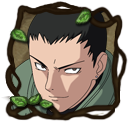

In [20]:
c = characters[3]
select_character(s, c)

In [21]:
def get_fidelity(session):
    for i in range(7):
        data = {'day':i+1}
        r = session.post(urls.FIDELITY, data=data)
        response_data = r.json()
        if response_data['success']:
            print('Fidelidade dia ' + str(i+1) + ' resgatada')
            return
    print('Não foi possível resgatar fidelidade ninja')
get_fidelity(s)

Não foi possível resgatar fidelidade ninja
